In [9]:
!pip install diffusers transformers accelerate

In [10]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch

In [11]:
!pip show torch

Name: torch
Version: 2.8.0+cu126
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [12]:
model_id1="dreamlike-art/dreamlike-diffusion-1.0"
model_id2="stabilityai/stable-diffusion-xl-base-1.0"
pipe = StableDiffusionPipeline.from_pretrained(model_id1, use_safetensors=True)

# Check if CUDA is available and move the pipeline accordingly
if torch.cuda.is_available():
    pipe = pipe.to("cuda")
else:
    pipe = pipe.to("cpu")
    print("CUDA not available, using CPU.")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
prompt= """dreamlikeart,a grungy woment with rinbow hair, travelling between dimensions,dynamic pose,happy,soft extreme bokeh,danity figure,long hair straight down,torn kawaii shirt and baggy jeans"""

In [14]:
image=pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

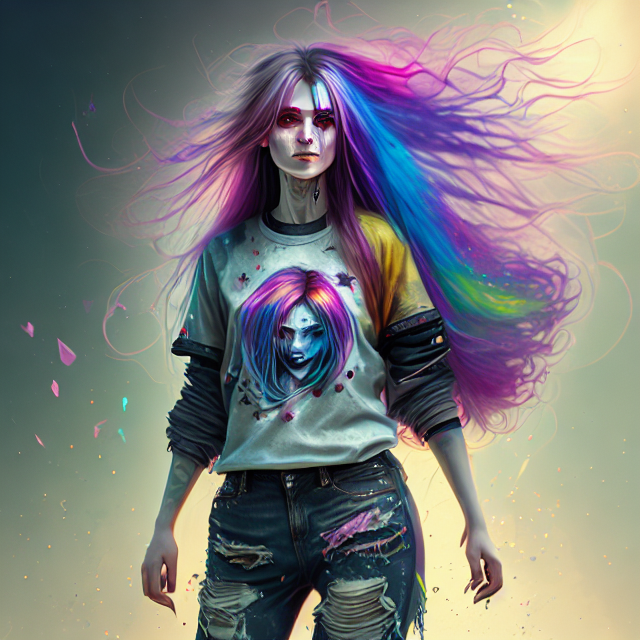

In [15]:
image

[PROMPT]: <PIL.Image.Image image mode=RGB size=640x640 at 0x7B2A99C9F050>


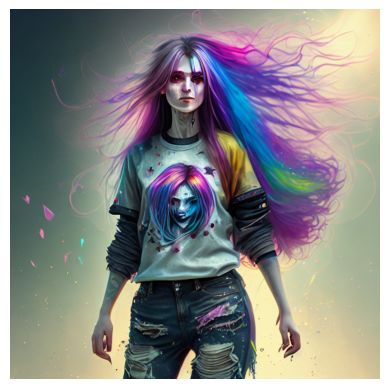

In [16]:
print("[PROMPT]:",image)
plt.imshow(image);
plt.axis('off');

In [17]:
def generate_image(pipe,prompt,params):
  img = pipe(prompt,**params).images
  num_images=len(img)
  if num_images>1:
    fig,ax=plt.subplots(nrows=1,ncols=num_images)
    for i in range(num_images):
      ax[i].imshow(img[i])
      ax[i].axis('off')
  else:
    fig=plt.figure()
    plt.imshow(img[0]);
    plt.axis('off');
  plt.tight_layout()

In [18]:
text1="""one boy lying on the bed and watching movie in phone"""

In [19]:
params={}

  0%|          | 0/50 [00:00<?, ?it/s]

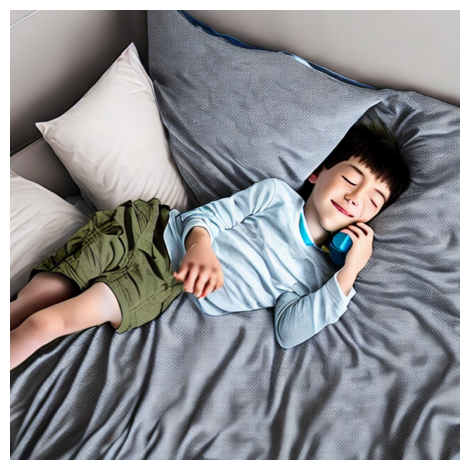

In [20]:
generate_image(pipe,text1,params)


  0%|          | 0/100 [00:00<?, ?it/s]

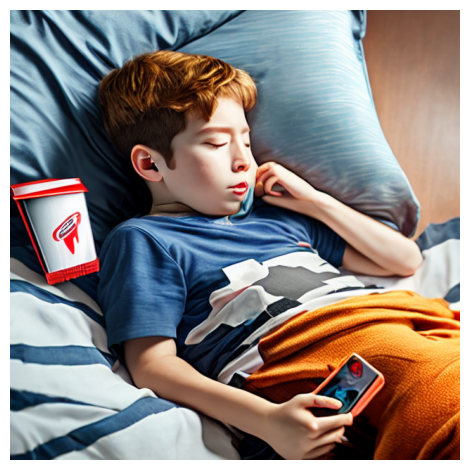

In [21]:
params = {'num_inference_steps':100}
generate_image(pipe,text1,params)

  0%|          | 0/100 [00:00<?, ?it/s]

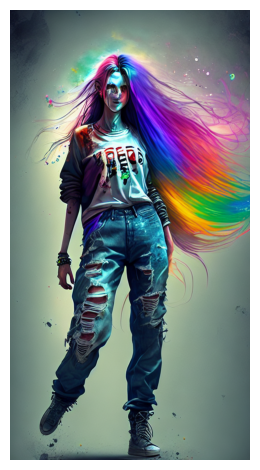

In [22]:
params={'num_inference_steps':100,'width':512,'height': int(1.5*640)}
generate_image(pipe,prompt,params)

  0%|          | 0/100 [00:00<?, ?it/s]

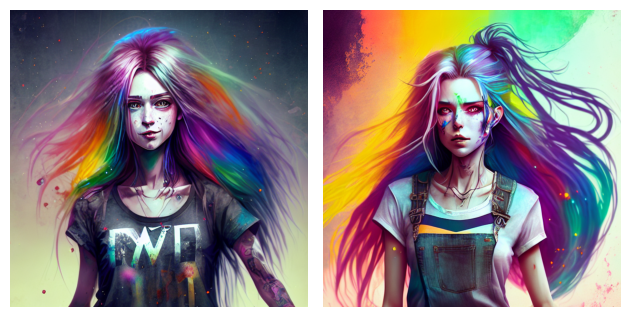

In [23]:
params ={'num_inference_steps':100, 'num_images_per_prompt':2}
generate_image(pipe,prompt,params)

  0%|          | 0/50 [00:00<?, ?it/s]

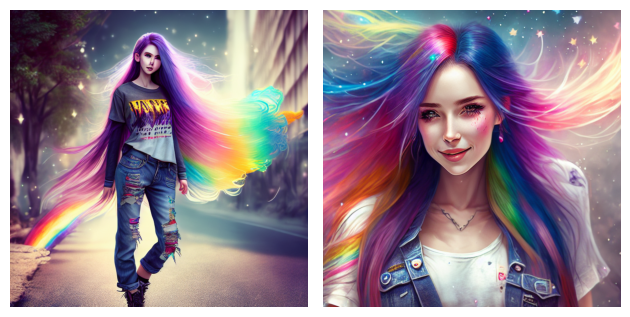

In [24]:
params={'num_interface_steps':100,'num_images_per_prompt':2,'negative_prompt':'ugly,distorted,low_quality'}
generate_image(pipe,prompt,params)

In [25]:
!pip install -q streamlit transformers diffusers accelerate

with open('guvi.py', 'w') as f:
  f.write('''
import streamlit as st
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
import torch

st.set_page_config(page_title="AI Story Generator with Image", page_icon="")
st.title("📙 AI STORY GENERATOR WITH IMAGE")
st.markdown("Type a creative prompt, choose your settings, and let the AI generate a multi-part story with images!")

# --- User Input Section ---
st.subheader("Story Idea and Settings")
prompt = st.text_input("🖋 Enter the core story idea:", "A young girl finds a secret door in her grandmother's attic.")

# Optional settings - these can be used later to influence text generation
genre = st.selectbox("Select Genre:", ["Fantasy", "Sci-Fi", "Mystery", "Comedy", "Other"])
tone = st.selectbox("Select Tone:", ["Lighthearted", "Dark", "Epic", "Humorous", "Serious"])
audience = st.selectbox("Target Audience:", ["Kids", "Teens", "Adults", "All"])

length = st.slider("🖋 Max Story Length (tokens)", min_value=100, max_value=600, value=300, step=20) # Increased max length for multi-part story

# --- Local Model Paths ---
# IMPORTANT: Replace these paths with the actual paths to your extracted model directories
LOCAL_TEXT_MODEL_PATH = "./local_text_model" # Example: Adjust this path as needed
LOCAL_IMAGE_PIPELINE_PATH = "./local_image_pipeline" # Example: Adjust this path as needed


# --- Load Text Generation Model and Tokenizer (from local) ---
@st.cache_resource
def load_text_model(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    # Move to GPU if available (optional, depends on local setup)
    if torch.cuda.is_available():
        model.to("cuda")
    return tokenizer, model

tokenizer, text_model = load_text_model(LOCAL_TEXT_MODEL_PATH)


# --- Load Image Generation Pipeline (from local) ---
@st.cache_resource
def load_image_pipeline(pipeline_path):
    pipe = StableDiffusionPipeline.from_pretrained(pipeline_path, use_safetensors=True)
    # Move to GPU if available (optional, depends on local setup)
    if torch.cuda.is_available():
        pipe.to("cuda")
    else:
        st.warning("CUDA not available, using CPU. Image generation may be slow.")
    return pipe

image_pipe = load_image_pipeline(LOCAL_IMAGE_PIPELINE_PATH)


# --- Generation Button ---
if st.button("Generate Story and Images"):
  with st.spinner("Generating your story and images..."):
    # --- Text Generation ---
    # Use the loaded local model
    inputs = tokenizer(prompt, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {key: value.to("cuda") for key, value in inputs.items()}

    generated_ids = text_model.generate(
        **inputs,
        max_length=length,
        num_return_sequences=1,
        temperature=0.85,
        top_k=50,
        top_p=0.92,
        repetition_penalty=1.5,
        no_repeat_ngram_size=3,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Basic attempt to split into segments (can be improved)
    segments = generated_text.split('.') # Split by sentence for now
    story_segments = [{"text": segment.strip() + '.', "prompt_for_image": f"Illustration for a story scene: {segment.strip()}"} for segment in segments if segment.strip()]

    st.subheader("Generated Story")

    # --- Display Story Segments and Generate Images ---
    for i, segment in enumerate(story_segments):
        st.markdown(f"**Scene {i+1}:**")
        st.write(segment["text"])

        # --- Image Generation ---
        if segment.get("prompt_for_image"):
            try:
                image = image_pipe(segment["prompt_for_image"]).images[0]
                st.image(image, caption=f"Scene {i+1} Illustration")
            except Exception as e:
                st.error(f"Error generating image for Scene {i+1}: {e}")
        else:
            st.info(f"No image prompt generated for Scene {i+1}.")


    # --- Optional Export/Enhancements Section (Placeholders) ---
    st.markdown("---")
    st.subheader("Options")
    # Placeholders for Export and Optional Enhancements
    # st.button("Export as PDF")
    # st.button("Export as Storybook")
    # st.button("Export as Image Gallery")
    # st.checkbox("Enable Narration")
    # st.checkbox("Add Background Music")
  ''')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 121.2 MB/s eta 0:00:00


In [26]:
with open('guvi.py', 'w') as f:
  f.write('''
import streamlit as st
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
import torch

st.set_page_config(page_title="AI Story Generator with Image", page_icon="")
st.title("📙 AI STORY GENERATOR WITH IMAGE")
st.markdown("Type a creative prompt, choose your settings, and let the AI generate a multi-part story with images!")

# --- User Input Section ---
st.subheader("Story Idea and Settings")
prompt = st.text_input("🖋 Enter the core story idea:", "A young girl finds a secret door in her grandmother's attic.")

# Optional settings - these can be used later to influence text generation
genre = st.selectbox("Select Genre:", ["Fantasy", "Sci-Fi", "Mystery", "Comedy", "Other"])
tone = st.selectbox("Select Tone:", ["Lighthearted", "Dark", "Epic", "Humorous", "Serious"])
audience = st.selectbox("Target Audience:", ["Kids", "Teens", "Adults", "All"])

length = st.slider("🖋 Max Story Length per part (tokens)", min_value=100, max_value=300, value=200, step=20) # Increased max length for multi-part story

# --- Local Model Paths ---
# IMPORTANT: Replace these paths with the actual paths to your extracted model directories
LOCAL_TEXT_MODEL_PATH = "./local_text_model" # Example: Adjust this path as needed
LOCAL_IMAGE_PIPELINE_PATH = "./local_image_pipeline" # Example: Adjust this path as needed


# --- Load Text Generation Model and Tokenizer (from local) ---
@st.cache_resource
def load_text_model(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    # Move to GPU if available (optional, depends on local setup)
    if torch.cuda.is_available():
        model.to("cuda")
    return tokenizer, model

tokenizer, text_model = load_text_model(LOCAL_TEXT_MODEL_PATH)


# --- Load Image Generation Pipeline (from local) ---
@st.cache_resource
def load_image_pipeline(pipeline_path):
    pipe = StableDiffusionPipeline.from_pretrained(pipeline_path, use_safetensors=True)
    # Move to GPU if available (optional, depends on local setup)
    if torch.cuda.is_available():
        pipe.to("cuda")
    else:
        st.warning("CUDA not available, using CPU. Image generation may be slow.")
    return pipe

image_pipe = load_image_pipeline(LOCAL_IMAGE_PIPELINE_PATH)


# --- Generation Button ---
if st.button("Generate Story and Images"):
  with st.spinner("Generating your story and images..."):
    story_parts = ["Introduction", "Conflict", "Climax", "Resolution"]
    full_story = ""
    story_segments_for_images = []

    for part in story_parts:
        part_prompt = f"Write the {part} for a {genre} story with a {tone} tone about: {prompt}"
        inputs = tokenizer(part_prompt, return_tensors="pt")
        if torch.cuda.is_available():
            inputs = {key: value.to("cuda") for key, value in inputs.items()}

        generated_ids = text_model.generate(
            **inputs,
            max_length=len(tokenizer(part_prompt).input_ids) + length,
            num_return_sequences=1,
            temperature=0.85,
            top_k=50,
            top_p=0.92,
            repetition_penalty=1.5,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Simple transition
        transition = ""
        if part == "Introduction":
            transition = "\\n\\n"
        elif part == "Conflict":
            transition = "\\n\\nHowever, "
        elif part == "Climax":
            transition = "\\n\\nSuddenly, "
        elif part == "Resolution":
            transition = "\\n\\nIn the end, "

        full_story += generated_text + transition
        story_segments_for_images.append({"text": generated_text.strip(), "prompt_for_image": f"Illustration for the {part} of a story: {generated_text.strip()[:100]}"}) # Use first 100 chars for image prompt


    st.subheader("Generated Story")

    # --- Display Story Segments and Generate Images ---
    for i, segment in enumerate(story_segments_for_images):
        st.markdown(f"**{story_parts[i]}:**")
        st.write(segment["text"])

        # --- Image Generation ---
        if segment.get("prompt_for_image"):
            try:
                image = image_pipe(segment["prompt_for_image"]).images[0]
                st.image(image, caption=f"{story_parts[i]} Illustration")
            except Exception as e:
                st.error(f"Error generating image for {story_parts[i]}: {e}")
        else:
            st.info(f"No image prompt generated for {story_parts[i]}.")


    # --- Optional Export/Enhancements Section (Placeholders) ---
    st.markdown("---")
    st.subheader("Options")
    # Placeholders for Export and Optional Enhancements
    # st.button("Export as PDF")
    # st.button("Export as Storybook")
    # st.button("Export as Image Gallery")
    # st.checkbox("Enable Narration")
    # st.checkbox("Add Background Music")
  ''')

In [27]:
with open('guvi.py', 'w') as f:
  f.write('''
import streamlit as st
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
import torch
import re # Import regular expression library

st.set_page_config(page_title="AI Story Generator with Image", page_icon="")
st.title("📙 AI STORY GENERATOR WITH IMAGE")
st.markdown("Type a creative prompt, choose your settings, and let the AI generate a multi-part story with images!")

# --- User Input Section ---
st.subheader("Story Idea and Settings")
prompt = st.text_input("🖋 Enter the core story idea:", "A young girl finds a secret door in her grandmother's attic.")

# Optional settings - these can be used later to influence text generation
genre = st.selectbox("Select Genre:", ["Fantasy", "Sci-Fi", "Mystery", "Comedy", "Other"])
tone = st.selectbox("Select Tone:", ["Lighthearted", "Dark", "Epic", "Humorous", "Serious"])
audience = st.selectbox("Target Audience:", ["Kids", "Teens", "Adults", "All"])

length = st.slider("🖋 Max Story Length per part (tokens)", min_value=100, max_value=300, value=200, step=20) # Increased max length for multi-part story

# --- Local Model Paths ---
# IMPORTANT: Replace these paths with the actual paths to your extracted model directories
LOCAL_TEXT_MODEL_PATH = "./local_text_model" # Example: Adjust this path as needed
LOCAL_IMAGE_PIPELINE_PATH = "./local_image_pipeline" # Example: Adjust this path as needed


# --- Load Text Generation Model and Tokenizer (from local) ---
@st.cache_resource
def load_text_model(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    # Move to GPU if available (optional, depends on local setup)
    if torch.cuda.is_available():
        model.to("cuda")
    return tokenizer, model

tokenizer, text_model = load_text_model(LOCAL_TEXT_MODEL_PATH)


# --- Load Image Generation Pipeline (from local) ---
@st.cache_resource
def load_image_pipeline(pipeline_path):
    pipe = StableDiffusionPipeline.from_pretrained(pipeline_path, use_safetensors=True)
    # Move to GPU if available (optional, depends on local setup)
    if torch.cuda.is_available():
        pipe.to("cuda")
    else:
        st.warning("CUDA not available, using CPU. Image generation may be slow.")
    return pipe

image_pipe = load_image_pipeline(LOCAL_IMAGE_PIPELINE_PATH)

# --- Function to generate image prompt based on story segment content ---
def generate_image_prompt(segment_text, part, genre, tone):
    # Simple keyword extraction (can be enhanced with more sophisticated NLP)
    keywords = re.findall(r'\b\w{4,}\b', segment_text) # Extract words with 4 or more characters
    # Filter out common words and keep unique ones
    common_words = set(["the", "and", "a", "of", "to", "in", "is", "it", "that", "on", "with", "for", "by", "this", "about", "are", "from", "was", "were"])
    filtered_keywords = [word for word in keywords if word.lower() not in common_words]
    unique_keywords = list(set(filtered_keywords))

    # Construct the prompt
    image_prompt = f"Illustration for the {part} of a {genre} story with a {tone} tone. Focus on: {', '.join(unique_keywords[:10])}. Scene description: {segment_text[:200]}..." # Use up to 10 unique keywords and a snippet of the text

    return image_prompt

# --- Generation Button ---
if st.button("Generate Story and Images"):
  with st.spinner("Generating your story and images..."):
    story_parts = ["Introduction", "Conflict", "Climax", "Resolution"]
    full_story = ""
    story_segments_for_images = []

    for part in story_parts:
        part_prompt = f"Write the {part} for a {genre} story with a {tone} tone about: {prompt}"
        inputs = tokenizer(part_prompt, return_tensors="pt")
        if torch.cuda.is_available():
            inputs = {key: value.to("cuda") for key in inputs.keys()}


        generated_ids = text_model.generate(
            **inputs,
            max_length=len(tokenizer(part_prompt).input_ids) + length,
            num_return_sequences=1,
            temperature=0.85,
            top_k=50,
            top_p=0.92,
            repetition_penalty=1.5,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Simple transition
        transition = ""
        if part == "Introduction":
            transition = "\\n\\n"
        elif part == "Conflict":
            transition = "\\n\\nHowever, "
        elif part == "Climax":
            transition = "\\n\\nSuddenly, "
        elif part == "Resolution":
            transition = "\\n\\nIn the end, "

        full_story += generated_text + transition

        # Generate a more descriptive image prompt
        image_prompt = generate_image_prompt(generated_text.strip(), part, genre, tone)
        story_segments_for_images.append({"text": generated_text.strip(), "prompt_for_image": image_prompt})


    st.subheader("Generated Story")

    # --- Display Story Segments and Generate Images ---
    for i, segment in enumerate(story_segments_for_images):
        st.markdown(f"**{story_parts[i]}:**")
        st.write(segment["text"])

        # --- Image Generation ---
        if segment.get("prompt_for_image"):
            try:
                image = image_pipe(segment["prompt_for_image"]).images[0]
                st.image(image, caption=f"{story_parts[i]} Illustration")
            except Exception as e:
                st.error(f"Error generating image for {story_parts[i]}: {e}")
        else:
            st.info(f"No image prompt generated for {story_parts[i]}.")


    # --- Optional Export/Enhancements Section (Placeholders) ---
    st.markdown("---")
    st.subheader("Options")
    # Placeholders for Export and Optional Enhancements
    # st.button("Export as PDF")
    # st.button("Export as Storybook")
    # st.button("Export as Image Gallery")
    # st.checkbox("Enable Narration")
    # st.checkbox("Add Background Music")
  ''')

<>:59: SyntaxWarning: invalid escape sequence '\w'
<>:59: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-290484676.py:59: SyntaxWarning: invalid escape sequence '\w'
  keywords = re.findall(r'\b\w{4,}\b', segment_text) # Extract words with 4 or more characters


In [28]:
!pip install streamlit

In [28]:
import streamlit as st
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
import torch
import re
import io
import zipfile
from PIL import Image
# import reportlab # Uncomment if implementing PDF export

st.set_page_config(page_title="AI Story Generator with Image", page_icon="")
st.title("📙 AI STORY GENERATOR WITH IMAGE")
st.markdown("Type a creative prompt, choose your settings, and let the AI generate a multi-part story with images!")

# --- User Input Section ---
st.subheader("Story Idea and Settings")
prompt = st.text_input("🖋 Enter the core story idea:", "A young girl finds a secret door in her grandmother's attic.")

# Optional settings - these can be used later to influence text generation
genre = st.selectbox("Select Genre:", ["Fantasy", "Sci-Fi", "Mystery", "Comedy", "Other"])
tone = st.selectbox("Select Tone:", ["Lighthearted", "Dark", "Epic", "Humorous", "Serious"])
audience = st.selectbox("Target Audience:", ["Kids", "Teens", "Adults", "All"])

length = st.slider("🖋 Max Story Length per part (tokens)", min_value=100, max_value=300, value=200, step=20) # Increased max length for multi-part story

# --- Local Model Paths ---
# IMPORTANT: Replace these paths with actual valid Hugging Face model IDs or local paths to models
# formatted correctly for AutoTokenizer.from_pretrained and StableDiffusionPipeline.from_pretrained
LOCAL_TEXT_MODEL_PATH = "gpt2" # Example: Using a public model for demonstration
LOCAL_IMAGE_PIPELINE_PATH = "runwayml/stable-diffusion-v1-5" # Example: Using a public model for demonstration


# --- Load Text Generation Model and Tokenizer ---
@st.cache_resource
def load_text_model(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        # Move to GPU if available (optional, depends on local setup)
        if torch.cuda.is_available():
            model.to("cuda")
        return tokenizer, model
    except Exception as e:
        st.error(f"Error loading text model: {e}. Please ensure LOCAL_TEXT_MODEL_PATH is a valid Hugging Face model ID or a correctly formatted local path.")
        return None, None

tokenizer, text_model = load_text_model(LOCAL_TEXT_MODEL_PATH)


# --- Load Image Generation Pipeline ---
@st.cache_resource
def load_image_pipeline(pipeline_path):
    try:
        pipe = StableDiffusionPipeline.from_pretrained(pipeline_path, use_safetensors=True)
        # Move to GPU if available (optional, depends on local setup)
        if torch.cuda.is_available():
            pipe.to("cuda")
        else:
            st.warning("CUDA not available, using CPU. Image generation may be slow.")
        return pipe
    except Exception as e:
        st.error(f"Error loading image pipeline: {e}. Please ensure LOCAL_IMAGE_PIPELINE_PATH is a valid Hugging Face model ID or a correctly formatted local path.")
        return None

image_pipe = load_image_pipeline(LOCAL_IMAGE_PIPELINE_PATH)


# --- Function to generate image prompt based on story segment content ---
def generate_image_prompt(segment_text, part, genre, tone):
    # Simple keyword extraction (can be enhanced with more sophisticated NLP)
    keywords = re.findall(r'\b\w{4,}\b', segment_text) # Extract words with 4 or more characters
    # Filter out common words and keep unique ones
    common_words = set(["the", "and", "a", "of", "to", "in", "is", "it", "that", "on", "with", "for", "by", "this", "about", "are", "from", "was", "were"])
    filtered_keywords = [word for word in keywords if word.lower() not in common_words]
    unique_keywords = list(set(filtered_keywords))

    # Construct the prompt
    image_prompt = f"Illustration for the {part} of a {genre} story with a {tone} tone. Focus on: {', '.join(unique_keywords[:10])}. Scene description: {segment_text[:200]}..." # Use up to 10 unique keywords and a snippet of the text

    return image_prompt

# --- Generation Button ---
if st.button("Generate Story and Images"):
    if tokenizer is not None and text_model is not None and image_pipe is not None:
        with st.spinner("Generating your story and images..."):
            story_parts = ["Introduction", "Conflict", "Climax", "Resolution"]
            full_story = ""
            story_segments_for_images = []

            for part in story_parts:
                part_prompt = f"Write the {part} for a {genre} story with a {tone} tone about: {prompt}"
                inputs = tokenizer(part_prompt, return_tensors="pt")
                if torch.cuda.is_available():
                    inputs = {key: value.to("cuda") for key in inputs.keys()}

                generated_ids = text_model.generate(
                    **inputs,
                    max_length=len(tokenizer(part_prompt).input_ids) + length,
                    num_return_sequences=1,
                    temperature=0.85,
                    top_k=50,
                    top_p=0.92,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.eos_token_id
                )
                generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

                # Simple transition
                transition = ""
                if part == "Introduction":
                    transition = "\\n\\n"
                elif part == "Conflict":
                    transition = "\\n\\nHowever, "
                elif part == "Climax":
                    transition = "\\n\\nSuddenly, "
                elif part == "Resolution":
                    transition = "\\n\\nIn the end, "

                full_story += generated_text + transition

                # Generate a more descriptive image prompt
                image_prompt = generate_image_prompt(generated_text.strip(), part, genre, tone)
                story_segments_for_images.append({"text": generated_text.strip(), "prompt_for_image": image_prompt, "image": None}) # Add a placeholder for the generated image


            st.subheader("Generated Story")

            # --- Display Story Segments and Generate Images ---
            for i, segment in enumerate(story_segments_for_images):
                st.markdown(f"**{story_parts[i]}:**")
                st.write(segment["text"])

                # --- Image Generation ---
                if segment.get("prompt_for_image"):
                    try:
                        image = image_pipe(segment["prompt_for_image"]).images[0]
                        segment["image"] = image # Store the generated image
                        st.image(image, caption=f"{story_parts[i]} Illustration")
                    except Exception as e:
                        st.error(f"Error generating image for {story_parts[i]}: {e}")
                else:
                    st.info(f"No image prompt generated for {story_parts[i]}.")


            # --- Optional Export/Enhancements Section ---
            st.markdown("---")
            st.subheader("Options")

            # Store story data in session state for export
            st.session_state['story_data'] = story_segments_for_images
            st.session_state['full_story_text'] = full_story
    else:
        st.error("Model loading failed. Please check your model paths.")


# --- Export Functionality ---
if 'story_data' in st.session_state and st.session_state['story_data']:
    story_segments_for_images = st.session_state['story_data']
    full_story_text = st.session_state['full_story_text']
    story_parts = ["Introduction", "Conflict", "Climax", "Resolution"] # Define story_parts again for the export section

    # Export as Text File
    st.download_button(
        label="Export as Text File",
        data=full_story_text,
        file_name="story.txt",
        mime="text/plain"
    )

    # Export as Image Gallery (ZIP file of images)
    if any(segment["image"] is not None for segment in story_segments_for_images):
        with io.BytesIO() as archive:
            with zipfile.ZipFile(archive, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for i, segment in enumerate(story_segments_for_images):
                    if segment["image"]:
                        img_byte_arr = io.BytesIO()
                        segment["image"].save(img_byte_arr, format='PNG')
                        zipf.writestr(f'scene_{i+1}_{story_parts[i].lower().replace(" ", "_")}.png', img_byte_arr.getvalue())
            st.download_button(
                label="Export as Image Gallery (ZIP)",
                data=archive.getvalue(),
                file_name="story_images.zip",
                mime="application/zip"
            )

    # Placeholder for Export as PDF (requires additional libraries like reportlab)
    # st.markdown("*(PDF export requires additional libraries and implementation)*")

    # Placeholder for Export as Storybook (requires custom formatting/HTML generation)
    # st.markdown("*(Storybook export requires custom formatting and implementation)*")

In [29]:
!pip install pyngrok

In [30]:
import streamlit as st
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
import torch
import re
import io
import zipfile
from PIL import Image
# import reportlab # Uncomment if implementing PDF export

st.set_page_config(page_title="AI Story Generator with Image", page_icon="")
st.title("📙 AI STORY GENERATOR WITH IMAGE")
st.markdown("Type a creative prompt, choose your settings, and let the AI generate a multi-part story with images!")

# --- User Input Section ---
st.subheader("Story Idea and Settings")
prompt = st.text_input("🖋 Enter the core story idea:", "A young girl finds a secret door in her grandmother's attic.")

# Optional settings - these can be used later to influence text generation
genre = st.selectbox("Select Genre:", ["Fantasy", "Sci-Fi", "Mystery", "Comedy", "Other"])
tone = st.selectbox("Select Tone:", ["Lighthearted", "Dark", "Epic", "Humorous", "Serious"])
audience = st.selectbox("Target Audience:", ["Kids", "Teens", "Adults", "All"])

length = st.slider("🖋 Max Story Length per part (tokens)", min_value=100, max_value=300, value=200, step=20) # Increased max length for multi-part story

# --- Local Model Paths ---
# IMPORTANT: Replace these paths with actual valid Hugging Face model IDs or local paths to models
# formatted correctly for AutoTokenizer.from_pretrained and StableDiffusionPipeline.from_pretrained
LOCAL_TEXT_MODEL_PATH = "gpt2" # Example: Using a public model for demonstration
LOCAL_IMAGE_PIPELINE_PATH = "runwayml/stable-diffusion-v1-5" # Example: Using a public model for demonstration


# --- Load Text Generation Model and Tokenizer ---
@st.cache_resource
def load_text_model(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        # Move to GPU if available (optional, depends on local setup)
        if torch.cuda.is_available():
            model.to("cuda")
        return tokenizer, model
    except Exception as e:
        st.error(f"Error loading text model: {e}. Please ensure LOCAL_TEXT_MODEL_PATH is a valid Hugging Face model ID or a correctly formatted local path.")
        return None, None

tokenizer, text_model = load_text_model(LOCAL_TEXT_MODEL_PATH)


# --- Load Image Generation Pipeline ---
@st.cache_resource
def load_image_pipeline(pipeline_path):
    try:
        pipe = StableDiffusionPipeline.from_pretrained(pipeline_path, use_safetensors=True)
        # Move to GPU if available (optional, depends on local setup)
        if torch.cuda.is_available():
            pipe.to("cuda")
        else:
            st.warning("CUDA not available, using CPU. Image generation may be slow.")
        return pipe
    except Exception as e:
        st.error(f"Error loading image pipeline: {e}. Please ensure LOCAL_IMAGE_PIPELINE_PATH is a valid Hugging Face model ID or a correctly formatted local path.")
        return None

image_pipe = load_image_pipeline(LOCAL_IMAGE_PIPELINE_PATH)


# --- Function to generate image prompt based on story segment content ---
def generate_image_prompt(segment_text, part, genre, tone):
    # Simple keyword extraction (can be enhanced with more sophisticated NLP)
    keywords = re.findall(r'\b\w{4,}\b', segment_text) # Extract words with 4 or more characters
    # Filter out common words and keep unique ones
    common_words = set(["the", "and", "a", "of", "to", "in", "is", "it", "that", "on", "with", "for", "by", "this", "about", "are", "from", "was", "were"])
    filtered_keywords = [word for word in keywords if word.lower() not in common_words]
    unique_keywords = list(set(filtered_keywords))

    # Construct the prompt
    image_prompt = f"Illustration for the {part} of a {genre} story with a {tone} tone. Focus on: {', '.join(unique_keywords[:10])}. Scene description: {segment_text[:200]}..." # Use up to 10 unique keywords and a snippet of the text

    return image_prompt

# --- Generation Button ---
if st.button("Generate Story and Images"):
    if tokenizer is not None and text_model is not None and image_pipe is not None:
        with st.spinner("Generating your story and images..."):
            story_parts = ["Introduction", "Conflict", "Climax", "Resolution"]
            full_story = ""
            story_segments_for_images = []

            for part in story_parts:
                part_prompt = f"Write the {part} for a {genre} story with a {tone} tone about: {prompt}"
                inputs = tokenizer(part_prompt, return_tensors="pt")
                if torch.cuda.is_available():
                    inputs = {key: value.to("cuda") for key in inputs.keys()}

                generated_ids = text_model.generate(
                    **inputs,
                    max_length=len(tokenizer(part_prompt).input_ids) + length,
                    num_return_sequences=1,
                    temperature=0.85,
                    top_k=50,
                    top_p=0.92,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.eos_token_id
                )
                generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

                # Simple transition
                transition = ""
                if part == "Introduction":
                    transition = "\\n\\n"
                elif part == "Conflict":
                    transition = "\\n\\nHowever, "
                elif part == "Climax":
                    transition = "\\n\\nSuddenly, "
                elif part == "Resolution":
                    transition = "\\n\\nIn the end, "

                full_story += generated_text + transition

                # Generate a more descriptive image prompt
                image_prompt = generate_image_prompt(generated_text.strip(), part, genre, tone)
                story_segments_for_images.append({"text": generated_text.strip(), "prompt_for_image": image_prompt, "image": None}) # Add a placeholder for the generated image


            st.subheader("Generated Story")

            # --- Display Story Segments and Generate Images ---
            for i, segment in enumerate(story_segments_for_images):
                st.markdown(f"**{story_parts[i]}:**")
                st.write(segment["text"])

                # --- Image Generation ---
                if segment.get("prompt_for_image"):
                    try:
                        image = image_pipe(segment["prompt_for_image"]).images[0]
                        segment["image"] = image # Store the generated image
                        st.image(image, caption=f"{story_parts[i]} Illustration")
                    except Exception as e:
                        st.error(f"Error generating image for {story_parts[i]}: {e}")
                else:
                    st.info(f"No image prompt generated for {story_parts[i]}.")


            # --- Optional Export/Enhancements Section ---
            st.markdown("---")
            st.subheader("Options")

            # Store story data in session state for export
            st.session_state['story_data'] = story_segments_for_images
            st.session_state['full_story_text'] = full_story
    else:
        st.error("Model loading failed. Please check your model paths.")


# --- Export Functionality ---
if 'story_data' in st.session_state and st.session_state['story_data']:
    story_segments_for_images = st.session_state['story_data']
    full_story_text = st.session_state['full_story_text']
    story_parts = ["Introduction", "Conflict", "Climax", "Resolution"] # Define story_parts again for the export section

    # Export as Text File
    st.download_button(
        label="Export as Text File",
        data=full_story_text,
        file_name="story.txt",
        mime="text/plain"
    )

    # Export as Image Gallery (ZIP file of images)
    if any(segment["image"] is not None for segment in story_segments_for_images):
        with io.BytesIO() as archive:
            with zipfile.ZipFile(archive, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for i, segment in enumerate(story_segments_for_images):
                    if segment["image"]:
                        img_byte_arr = io.BytesIO()
                        segment["image"].save(img_byte_arr, format='PNG')
                        zipf.writestr(f'scene_{i+1}_{story_parts[i].lower().replace(" ", "_")}.png', img_byte_arr.getvalue())
            st.download_button(
                label="Export as Image Gallery (ZIP)",
                data=archive.getvalue(),
                file_name="story_images.zip",
                mime="application/zip"
            )

    # Placeholder for Export as PDF (requires additional libraries like reportlab)
    # st.markdown("*(PDF export requires additional libraries and implementation)*")

    # Placeholder for Export as Storybook (requires custom formatting/HTML generation)
    # st.markdown("*(Storybook export requires custom formatting and implementation)*")

2025-09-07 17:56:56.689 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:56:56.690 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:56:56.781 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-07 17:56:56.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:56:56.783 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:56:56.784 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:56:56.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

2025-09-07 17:56:57.323 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:56:57.328 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:56:57.331 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

2025-09-07 17:57:11.170 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.183 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.189 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.194 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

2025-09-07 17:57:11.697 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.698 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 17:57:11.699 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

2025-09-07 18:03:41.065 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 18:03:41.066 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 18:03:41.069 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 18:03:41.071 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 18:03:41.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 18:03:41.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 18:03:41.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-07 18:03:41.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [47]:
%%writefile guvi.py
# Set environment variable to potentially help with CUDA memory fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")


import streamlit as st
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
import torch
import re
import io
import zipfile
from PIL import Image
# import reportlab # Uncomment if implementing PDF export

st.set_page_config(page_title="AI Story Generator with Image", page_icon="")
st.title("📙 AI STORY GENERATOR WITH IMAGE")
st.markdown("Type a creative prompt, choose your settings, and let the AI generate a multi-part story with images!")

# --- User Input Section ---
st.subheader("Story Idea and Settings")
prompt = st.text_input("🖋 Enter the core story idea:", "A young girl finds a secret door in her grandmother's attic.")

# Optional settings - these can be used later to influence text generation
genre = st.selectbox("Select Genre:", ["Fantasy", "Sci-Fi", "Mystery", "Comedy", "Other"])
tone = st.selectbox("Select Tone:", ["Lighthearted", "Dark", "Epic", "Humorous", "Serious"])
audience = st.selectbox("Target Audience:", ["Kids", "Teens", "Adults", "All"])

length = st.slider("🖋 Max Story Length per part (tokens)", min_value=100, max_value=300, value=200, step=20) # Increased max length for multi-part story

# --- Local Model Paths ---
# IMPORTANT: Replace these paths with actual valid Hugging Face model IDs or local paths to models
# formatted correctly for AutoTokenizer.from_pretrained and StableDiffusionPipeline.from_pretrained
LOCAL_TEXT_MODEL_PATH = "gpt2" # Example: Using a public model for demonstration
# Consider using a smaller model or torch_dtype=torch.float16 if you encounter CUDA memory issues
LOCAL_IMAGE_PIPELINE_PATH = "runwayml/stable-diffusion-v1-5" # Example: Using a public model for demonstration


# --- Load Text Generation Model and Tokenizer ---
@st.cache_resource
def load_text_model(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        # Move to GPU if available (optional, depends on local setup)
        if torch.cuda.is_available():
            model.to("cuda")
        return tokenizer, model
    except Exception as e:
        st.error(f"Error loading text model: {e}. Please ensure LOCAL_TEXT_MODEL_PATH is a valid Hugging Face model ID or a correctly formatted local path.")
        return None, None

tokenizer, text_model = load_text_model(LOCAL_TEXT_MODEL_PATH)


# --- Load Image Generation Pipeline ---
@st.cache_resource
def load_image_pipeline(pipeline_path):
    try:
        # Use torch_dtype=torch.float16 to potentially reduce memory usage
        pipe = StableDiffusionPipeline.from_pretrained(pipeline_path, use_safetensors=True, torch_dtype=torch.float16)
        # Move to GPU if available (optional, depends on local setup)
        if torch.cuda.is_available():
            pipe.to("cuda")
        else:
            st.warning("CUDA not available, using CPU. Image generation may be slow.")
        return pipe
    except Exception as e:
        st.error(f"Error loading image pipeline: {e}. Please ensure LOCAL_IMAGE_PIPELINE_PATH is a valid Hugging Face model ID or a correctly formatted local path.")
        return None

image_pipe = load_image_pipeline(LOCAL_IMAGE_PIPELINE_PATH)


# --- Function to generate image prompt based on story segment content ---
def generate_image_prompt(segment_text, part, genre, tone):
    # Simple keyword extraction (can be enhanced with more sophisticated NLP)
    keywords = re.findall(r'\b\w{4,}\b', segment_text) # Extract words with 4 or more characters
    # Filter out common words and keep unique ones
    common_words = set(["the", "and", "a", "of", "to", "in", "is", "it", "that", "on", "with", "for", "by", "this", "about", "are", "from", "was", "were"])
    filtered_keywords = [word for word in keywords if word.lower() not in common_words]
    unique_keywords = list(set(filtered_keywords))

    # Construct the prompt - make it more descriptive for better image generation and add emphasis on color
    image_prompt = f"Vibrant and detailed illustration for the {part} of a {genre} story with a {tone} tone. Scene focuses on: {', '.join(unique_keywords[:15])}. Full scene description: {segment_text[:300]}. Emphasize color and completeness." # Increased keywords and description length, added emphasis on color and completeness

    return image_prompt

# --- Generation Button ---
if st.button("Generate Story and Images"):
    if tokenizer is not None and text_model is not None and image_pipe is not None:
        with st.spinner("Generating your story and images..."):
            story_parts = ["Introduction", "Conflict", "Climax", "Resolution"]
            full_story = ""
            story_segments_for_images = []
            previous_text = "" # Keep track of previous text for coherence

            for i, part in enumerate(story_parts):
                # Refined prompt for text generation
                # We'll provide the overall prompt and the previous text to guide the generation
                if part == "Introduction":
                    part_prompt = f"Write a {genre} story with a {tone} tone for {audience} about: {prompt}\n\n{part}:"
                else:
                     # Provide more context for subsequent parts and explicitly ask for a continuation
                     part_prompt = f"{full_story.strip()}\n\nWrite the {part} of the story, continuing from the previous part:"


                inputs = tokenizer(part_prompt, return_tensors="pt")
                if torch.cuda.is_available():
                    inputs = {key: value.to("cuda") for key, value in inputs.items()}

                # Adjust max_length for subsequent parts to avoid exceeding limits
                # Also increase max_length slightly for Climax to encourage more text
                current_max_length = len(tokenizer(part_prompt).input_ids) + length
                if i > 0: # For Conflict, Climax, Resolution, adjust max length based on previous text
                    current_max_length = len(tokenizer(full_story).input_ids) + length + (50 if part == "Climax" else 0) # Add extra tokens for Climax


                generated_ids = text_model.generate(
                    **inputs,
                    max_length=current_max_length,
                    num_return_sequences=1,
                    temperature=0.85,
                    top_k=50,
                    top_p=0.92,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.eos_token_id
                )
                generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

                # Remove the input prompt from the generated text
                # Use regex to remove the part prompt more reliably
                generated_text = re.sub(re.escape(part_prompt), "", generated_text, 1).strip()


                # Update previous_text for the next iteration
                previous_text = generated_text


                full_story += generated_text + "\\n\\n" # Add a newline for separation

                # Generate a more descriptive image prompt
                image_prompt = generate_image_prompt(generated_text.strip(), part, genre, tone)
                story_segments_for_images.append({"text": generated_text.strip(), "prompt_for_image": image_prompt, "image": None}) # Add a placeholder for the generated image


            st.subheader("Generated Story")

            # --- Display Story Segments and Generate Images ---
            for i, segment in enumerate(story_segments_for_images):
                st.markdown(f"**{story_parts[i]}:**")
                st.write(segment["text"])

                # --- Image Generation ---
                if segment.get("prompt_for_image"):
                    try:
                        image = image_pipe(segment["prompt_for_image"]).images[0]
                        segment["image"] = image # Store the generated image
                        st.image(image, caption=f"{story_parts[i]} Illustration")
                    except Exception as e:
                        st.error(f"Error generating image for {story_parts[i]}: {e}")
                else:
                    st.info(f"No image prompt generated for {story_parts[i]}.")


            # --- Optional Export/Enhancements Section ---
            st.markdown("---")
            st.subheader("Options")

            # Store story data in session state for export
            st.session_state['story_data'] = story_segments_for_images
            st.session_state['full_story_text'] = full_story
    else:
        st.error("Model loading failed. Please check your model paths.")


# --- Export Functionality ---
if 'story_data' in st.session_state and st.session_state['story_data']:
    story_segments_for_images = st.session_state['story_data']
    full_story_text = st.session_state['full_story_text']
    story_parts = ["Introduction", "Conflict", "Climax", "Resolution"] # Define story_parts again for the export section

    # Export as Text File
    st.download_button(
        label="Export as Text File",
        data=full_story_text,
        file_name="story.txt",
        mime="text/plain"
    )

    # Export as Image Gallery (ZIP file of images)
    if any(segment["image"] is not None for segment in story_segments_for_images):
        with io.BytesIO() as archive:
            with zipfile.ZipFile(archive, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for i, segment in enumerate(story_segments_for_images):
                    if segment["image"]:
                        img_byte_arr = io.BytesIO()
                        segment["image"].save(img_byte_arr, format='PNG')
                        zipf.writestr(f'scene_{i+1}_{story_parts[i].lower().replace(" ", "_")}.png', img_byte_arr.getvalue())
            st.download_button(
                label="Export as Image Gallery (ZIP)",
                data=archive.getvalue(),
                file_name="story_images.zip",
                mime="application/zip"
            )

    # Placeholder for Export as PDF (requires additional libraries like reportlab)
    # st.markdown("*(PDF export requires additional libraries and implementation)*")

    # Placeholder for Export as Storybook (requires custom formatting/HTML generation)
    # st.markdown("*(Storybook export requires custom formatting and implementation)*")

# --- Team Attribution ---
st.markdown("---") # Add a separator line
st.markdown("<p style='text-align: center;'>Team: The Glitch</p>", unsafe_allow_html=True) # Centered attribution

Overwriting guvi.py


In [33]:
import os

# Create .streamlit directory if it doesn't exist
if not os.path.exists('.streamlit'):
    os.makedirs('.streamlit')

# Write toml configuration file
config_content = """
[server]
enableCORS = true
enableXsrfProtection = false
"""
with open('.streamlit/config.toml', 'w') as f:
    f.write(config_content)

print("Created .streamlit/config.toml with necessary configurations.")

Created .streamlit/config.toml with necessary configurations.


In [48]:
from pyngrok import ngrok
import os
import threading
import time

# Terminate any active ngrok tunnels
print("Terminating existing ngrok tunnels...")
ngrok.kill()

# Set environment variable to potentially help with CUDA memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")


# Use the provided ngrok authtoken
NGROK_AUTH_TOKEN = "32MhBmqSbeLzF3l5sHA5XvXOdlj_67k12yrBbq6wkJHLTy8cv" # Replace with your actual auth token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)


# Define the Streamlit app file and port
STREAMLIT_APP_FILE = "guvi.py"
STREAMLIT_PORT = 8501

# Function to run Streamlit in a separate thread
def run_streamlit():
    # Use `streamlit run` command to run the app
    os.system(f"streamlit run {STREAMLIT_APP_FILE} &>/dev/null")

# Start Streamlit in a thread
print(f"Starting Streamlit app '{STREAMLIT_APP_FILE}' on port {STREAMLIT_PORT}...")
streamlit_thread = threading.Thread(target=run_streamlit)
streamlit_thread.daemon = True # Allow the main program to exit even if the thread is running
streamlit_thread.start()

# Wait a moment for Streamlit to start
time.sleep(5)

# Open a tunnel to the Streamlit port
try:
    print(f"Opening ngrok tunnel to port {STREAMLIT_PORT}...")
    public_url = ngrok.connect(STREAMLIT_PORT).public_url
    print(f"Streamlit app available at: {public_url}")
except Exception as e:
    print(f"Error creating ngrok tunnel: {e}")
    print("Please ensure Streamlit is running and your ngrok authtoken is correct.")

Terminating existing ngrok tunnels...
Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting Streamlit app 'guvi.py' on port 8501...
Opening ngrok tunnel to port 8501...
Streamlit app available at: https://0eee7d727174.ngrok-free.app


In [44]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Task
Save the current notebook and the `guvi.py` file, then upload them to the GitHub repository at "https://github.com/Shrshpathak/AI-Story-Generator-Hackathon.git", ensuring the notebook renders correctly on GitHub.

## Save notebook

### Subtask:
Save the current state of your Colab notebook.


## Download files

### Subtask:
Download both the `.ipynb` notebook file and the `guvi.py` file from Colab.
